In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('/content/drive/MyDrive/bankloan.csv')
# Drop irrelevant columns
data_cleaned = data.drop(columns=['ID', 'ZIP.Code'])

# Separate features and target variable
X = data_cleaned.drop('Personal.Loan', axis=1)
y = data_cleaned['Personal.Loan']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP.Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal.Loan       5000 non-null   int64  
 10  Securities.Account  5000 non-null   int64  
 11  CD.Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [ ]:
data.head()

,ID,Age,Experience,Income,ZIP.Code,Family,CCAvg,Education,Mortgage,Personal.Loan,Securities.Account,CD.Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


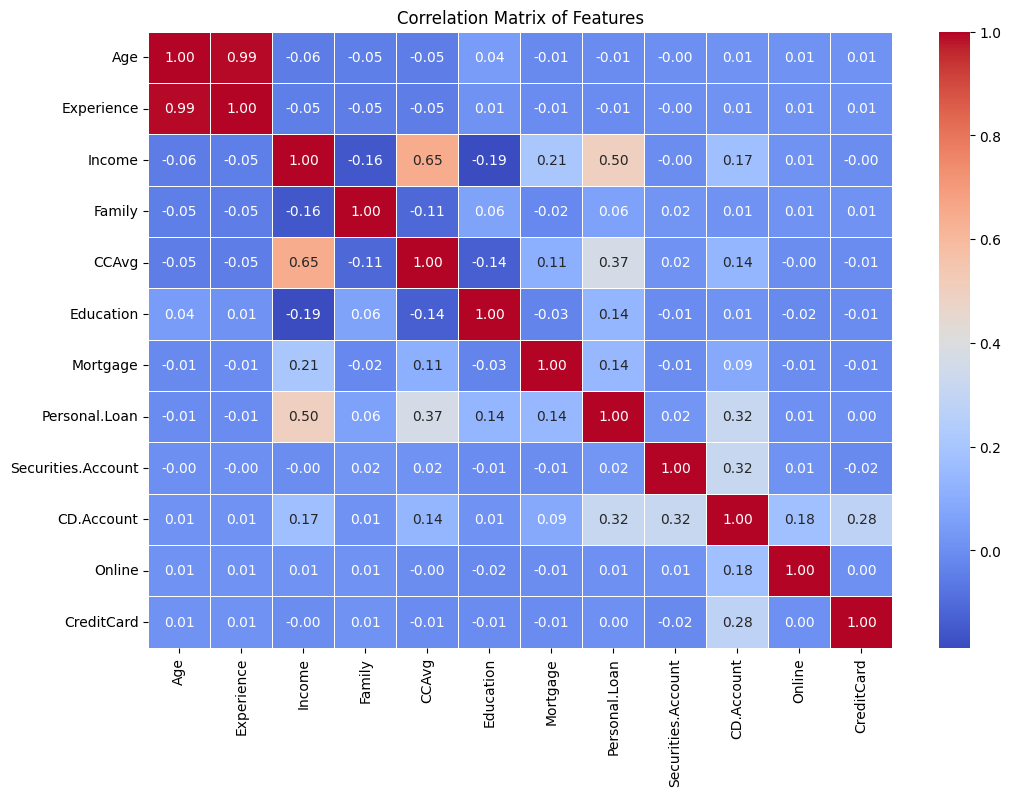

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns



# Calculate the correlation matrix

correlation_matrix = data_cleaned.corr()



# Plot the heatmap to visualize correlations between variables

plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix of Features")

plt.show()

In [ ]:
# Remove the 'Experience' column from the features
X_optimized = X.drop(columns=['Experience'])

# Split the optimized dataset into training and testing sets
X_train_opt, X_test_opt, y_train, y_test = train_test_split(X_optimized, y, test_size=0.2, random_state=42)

# Scale the numeric features again after removing 'Experience'

# Scale the numeric features for better model performance
scaler = StandardScaler()
X_train_opt_scaled = scaler.fit_transform(X_train_opt)
X_test_opt_scaled = scaler.transform(X_test_opt)



In [ ]:
# Create a new feature 'per_capita_income' by dividing 'Income' by 'Family'
data_cleaned['per_capita_income'] = data_cleaned['Income'] / data_cleaned['Family']

def age_group(age):
    if age <= 35:
        return 'Young'
    elif age <= 55:
        return 'Middle-aged'
    else:
        return 'Senior'

data_cleaned['age_group'] = data_cleaned['Age'].apply(age_group)

# Display the first few rows to confirm the new features
data_cleaned[['Income', 'Family', 'per_capita_income', 'Age', 'age_group']].head()


,Income,Family,per_capita_income,Age,age_group
0,49,4,12.250000,25,Young
1,34,3,11.333333,45,Middle-aged
2,11,1,11.000000,39,Middle-aged
3,100,1,100.000000,35,Young
4,45,4,11.250000,35,Young


In [ ]:
# Identify outliers in 'Income', 'CCAvg', and 'Mortgage' using the IQR method

def detect_outliers_iqr(data, column):
    """Detect outliers based on the IQR method."""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)], lower_bound, upper_bound

# Detect and report outliers in Income, CCAvg, and Mortgage
outliers_income, income_lower, income_upper = detect_outliers_iqr(data_cleaned, 'Income')
outliers_ccavg, ccavg_lower, ccavg_upper = detect_outliers_iqr(data_cleaned, 'CCAvg')
outliers_mortgage, mortgage_lower, mortgage_upper = detect_outliers_iqr(data_cleaned, 'Mortgage')

# Summarize findings for each feature
outlier_summary = {
    'Feature': ['Income', 'CCAvg', 'Mortgage'],
    'Lower Bound': [income_lower, ccavg_lower, mortgage_lower],
    'Upper Bound': [income_upper, ccavg_upper, mortgage_upper],
    'Number of Outliers': [len(outliers_income), len(outliers_ccavg), len(outliers_mortgage)]
}

outlier_summary


{'Feature': ['Income', 'CCAvg', 'Mortgage'],
 'Lower Bound': [-49.5, -2.0, -151.5],
 'Upper Bound': [186.5, 5.2, 252.5],
 'Number of Outliers': [96, 324, 291]}

In [ ]:
!pip install imbalanced-learn

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Check the initial class distribution for 'Personal.Loan'
class_distribution = Counter(y_train)

# Apply SMOTE to the training set to balance classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_opt_scaled, y_train)

# Check the new class distribution after applying SMOTE
balanced_class_distribution = Counter(y_train_balanced)

print("Original Class Distribution:", class_distribution)
print("Balanced Class Distribution:", balanced_class_distribution)


Original Class Distribution: Counter({0: 3625, 1: 375})
Balanced Class Distribution: Counter({0: 3625, 1: 3625})


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Define the models and hyperparameters for tuning
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.1, 1, 10, 100],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20, 30]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "n_estimators": [50, 100, 200]
        }
    }
}

# Initialize dictionaries to store best models and their performance
best_models = {}
results = {}

# Perform GridSearchCV for each model
for model_name, model_info in models.items():
    clf = GridSearchCV(model_info["model"], model_info["params"], cv=5, scoring="roc_auc", n_jobs=-1, verbose=1)
    clf.fit(X_train_opt_scaled, y_train)
    best_models[model_name] = clf.best_estimator_
    y_pred = clf.predict(X_test_opt_scaled)
    results[model_name] = {
        "Best Params": clf.best_params_,
        "Classification Report": classification_report(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, clf.predict_proba(X_test_opt_scaled)[:, 1])
    }

results


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:45:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 

{'Logistic Regression': {'Best Params': {'C': 0.1, 'solver': 'liblinear'},
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.96      0.99      0.98       895\n           1       0.91      0.64      0.75       105\n\n    accuracy                           0.95      1000\n   macro avg       0.93      0.82      0.86      1000\nweighted avg       0.95      0.95      0.95      1000\n',
  'ROC-AUC': 0.9693429103484971},
 'Random Forest': {'Best Params': {'max_depth': None, 'n_estimators': 100},
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.99      1.00      0.99       895\n           1       0.98      0.91      0.95       105\n\n    accuracy                           0.99      1000\n   macro avg       0.98      0.96      0.97      1000\nweighted avg       0.99      0.99      0.99      1000\n',
  'ROC-AUC': 0.9988933226922053},
 'XGBoost': {'Best Params': {'learning_rate': 0.01,

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

def display_model_results(results_dict):
    for model_name, model_results in results_dict.items():
        print(f"\n{'='*40}")
        print(f"Model: {model_name}")
        print(f"{'='*40}")

        # Display Best Parameters
        print("\nBest Parameters:")
        for param, value in model_results['Best Params'].items():
            print(f"  {param}: {value}")

        # Display ROC-AUC Score
        print(f"\nROC-AUC Score: {model_results['ROC-AUC']:.4f}")

# Helper function to convert classification report string to DataFrame
def classification_report_to_df(report_str):
    # Parse the classification report string to a DataFrame
    report_data = []
    lines = report_str.split('\n')
    for line in lines[2:len(lines)-3]:  # Skip header and footer lines
        row = {}
        row_data = line.split()
        if len(row_data) < 2:
            continue
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1-score'] = float(row_data[3])
        row['support'] = int(row_data[4])
        report_data.append(row)
    return pd.DataFrame.from_dict(report_data)

display_model_results(results)


Model: Logistic Regression

Best Parameters:
  C: 0.1
  solver: liblinear

ROC-AUC Score: 0.9693

Model: Random Forest

Best Parameters:
  max_depth: None
  n_estimators: 100

ROC-AUC Score: 0.9989

Model: XGBoost

Best Parameters:
  learning_rate: 0.01
  max_depth: 5
  n_estimators: 50

ROC-AUC Score: 0.9983


In [ ]:
# Re-running the model selection and tuning process due to the previous connection error

# Since we already defined models and parameters, retrying GridSearchCV for each model
best_models = {}
results = {}

try:
    for model_name, model_info in models.items():
        clf = GridSearchCV(model_info["model"], model_info["params"], cv=5, scoring="roc_auc", n_jobs=-1, verbose=1)
        clf.fit(X_train_opt_scaled, y_train)
        best_models[model_name] = clf.best_estimator_
        y_pred = clf.predict(X_test_opt_scaled)
        results[model_name] = {
            "Best Params": clf.best_params_,
            "Classification Report": classification_report(y_test, y_pred),
            "ROC-AUC": roc_auc_score(y_test, clf.predict_proba(X_test_opt_scaled)[:, 1])
        }
except Exception as e:
    results = str(e)

results


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:46:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 

{'Logistic Regression': {'Best Params': {'C': 0.1, 'solver': 'liblinear'},
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.96      0.99      0.98       895\n           1       0.91      0.64      0.75       105\n\n    accuracy                           0.95      1000\n   macro avg       0.93      0.82      0.86      1000\nweighted avg       0.95      0.95      0.95      1000\n',
  'ROC-AUC': 0.9693429103484971},
 'Random Forest': {'Best Params': {'max_depth': None, 'n_estimators': 100},
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.99      1.00      0.99       895\n           1       0.98      0.91      0.95       105\n\n    accuracy                           0.99      1000\n   macro avg       0.98      0.96      0.97      1000\nweighted avg       0.99      0.99      0.99      1000\n',
  'ROC-AUC': 0.9988933226922053},
 'XGBoost': {'Best Params': {'learning_rate': 0.01,

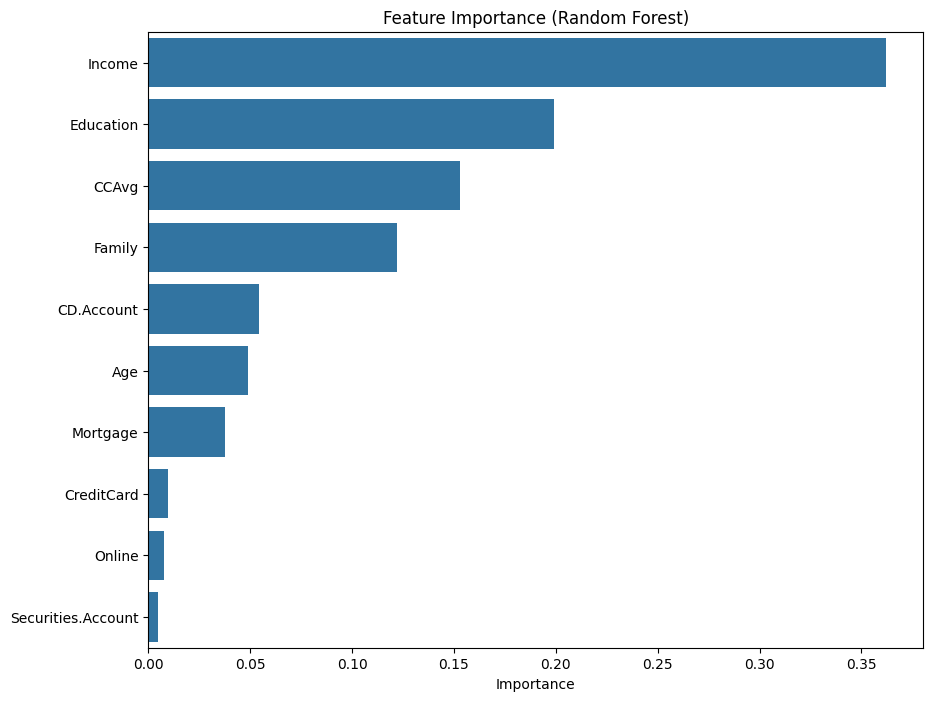

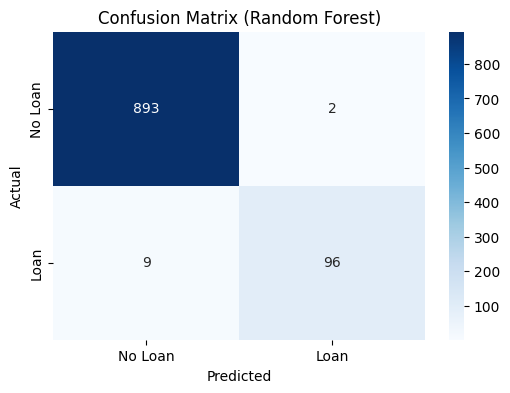

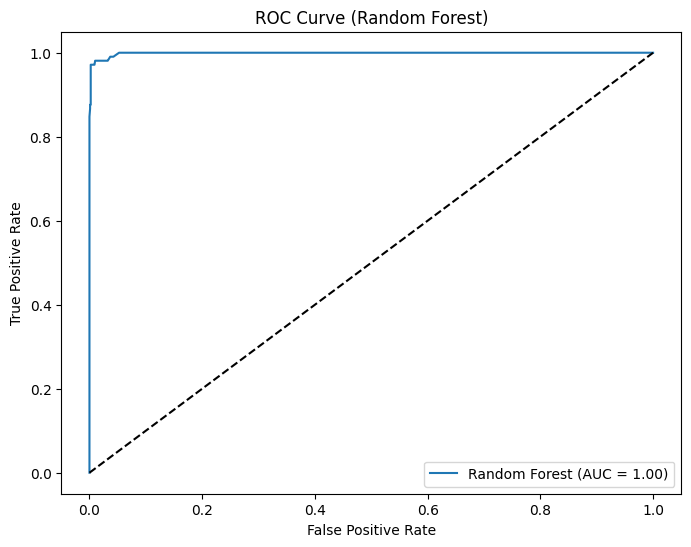

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
import numpy as np

# Feature Importance using Random Forest
best_rf_model = best_models["Random Forest"]
feature_importances = best_rf_model.feature_importances_
features = X_train_opt.columns  # Get feature names from the training set

# Sort features by importance
indices = np.argsort(feature_importances)[::-1]
sorted_features = [features[i] for i in indices]
sorted_importances = feature_importances[indices]

# Plot Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()

# Comprehensive Evaluation: Confusion Matrix
y_pred_rf = best_rf_model.predict(X_test_opt_scaled)
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Loan", "Loan"], yticklabels=["No Loan", "Loan"])
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve and AUC
y_prob_rf = best_rf_model.predict_proba(X_test_opt_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy of the Random Forest model on the test set
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_rf


0.989

In [ ]:
import joblib

# Save the model
joblib.dump(best_rf_model, 'model.joblib')

# Load the model
loaded_model = joblib.load('model.joblib')

# Predict using the model
example_features = [5, 1, 3, 5, 1, 4, 0, 2, 1, 1]  # Replace with appropriate feature values
prediction = loaded_model.predict([example_features])

if prediction[0] == 0:
    print("No Loan")
else:
    print("Loan")
print("Prediction:", prediction[0])


Loan
Prediction: 1
